https://www.kaggle.com/datasets/mohankrishnathalla/diabetes-health-indicators-dataset

### Dataset Description
The dataset includes patient profiles with features based on demographics, lifestyle habits, family history, and clinical measurements that are well-established indicators of diabetes risk. All data is generated using statistical distributions inspired by real-world medical research, ensuring privacy preservation while reflecting realistic health patterns.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.stats import f, ttest_ind, chi2_contingency
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

### **Importing**, **cleaning** and **modeling**

In [3]:
# PIPELINE (parte1)
df = pd.read_csv('./data/diabetes_dataset.csv')

# ordenando variaveis ordineis
df['education_level'] = df['education_level'].apply(lambda x: 
    f'1 {x}' if x == 'No formal' else 
    f'2 {x}' if x == 'Highschool' else 
    f'3 {x}' if x == 'Graduate' else 
    f'4 {x}' if x == 'Postgraduate' else None)
df['income_level'] = df['income_level'].apply(lambda x: 
    f'1 {x}' if x == 'Low' else f'2 {x}' if x == 'Lower-Middle' else f'3 {x}' if x == 'Middle' else f'4 {x}' if x == 'Upper-Middle' else f'5 {x}' if x == 'High' else None)

# trocando 0, 1 por No, Yes
for col in ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']:
    df[col] = df[col].replace({0:'No', 1:'Yes'})

display(df.head())
display(df.sample().iloc[0])

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,2 Highschool,2 Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,Yes
1,48,Female,White,2 Highschool,3 Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,No
2,60,Male,Hispanic,2 Highschool,3 Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,Yes
3,74,Female,Black,2 Highschool,1 Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,Yes
4,46,Male,White,3 Graduate,3 Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,Yes


age                                             70
gender                                      Female
ethnicity                                    White
education_level                       2 Highschool
income_level                              3 Middle
employment_status                         Employed
smoking_status                               Never
alcohol_consumption_per_week                     5
physical_activity_minutes_per_week             114
diet_score                                     2.3
sleep_hours_per_day                            8.9
screen_time_hours_per_day                     10.2
family_history_diabetes                        Yes
hypertension_history                           Yes
cardiovascular_history                          No
bmi                                           25.2
waist_to_hip_ratio                            0.84
systolic_bp                                    123
diastolic_bp                                    64
heart_rate                     

### **EDA**

In [4]:
print(df.shape)
display(
    pd.DataFrame({
        'Tipo': df.dtypes,
        'Qtde nulos': df.isnull().sum(),
        'Proporção nulos': df.isnull().mean(),
        'Qtde unicos': df.nunique(),
        'Exemplo unicos': df.apply(lambda x: x.unique()[:3])
    })
)

(100000, 31)


,Tipo,Qtde nulos,Proporção nulos,Qtde unicos,Exemplo unicos
age,int64,0,0.0,73,"[58, 48, 60]"
gender,object,0,0.0,3,"[Male, Female, Other]"
ethnicity,object,0,0.0,5,"[Asian, White, Hispanic]"
education_level,object,0,0.0,4,"[2 Highschool, 3 Graduate, 4 Postgraduate]"
income_level,object,0,0.0,5,"[2 Lower-Middle, 3 Middle, 1 Low]"
employment_status,object,0,0.0,4,"[Employed, Unemployed, Retired]"
smoking_status,object,0,0.0,3,"[Never, Former, Current]"
alcohol_consumption_per_week,int64,0,0.0,11,"[0, 1, 2]"
physical_activity_minutes_per_week,int64,0,0.0,620,"[215, 143, 57]"
diet_score,float64,0,0.0,101,"[5.7, 6.7, 6.4]"


#### *Univariate* Analysis

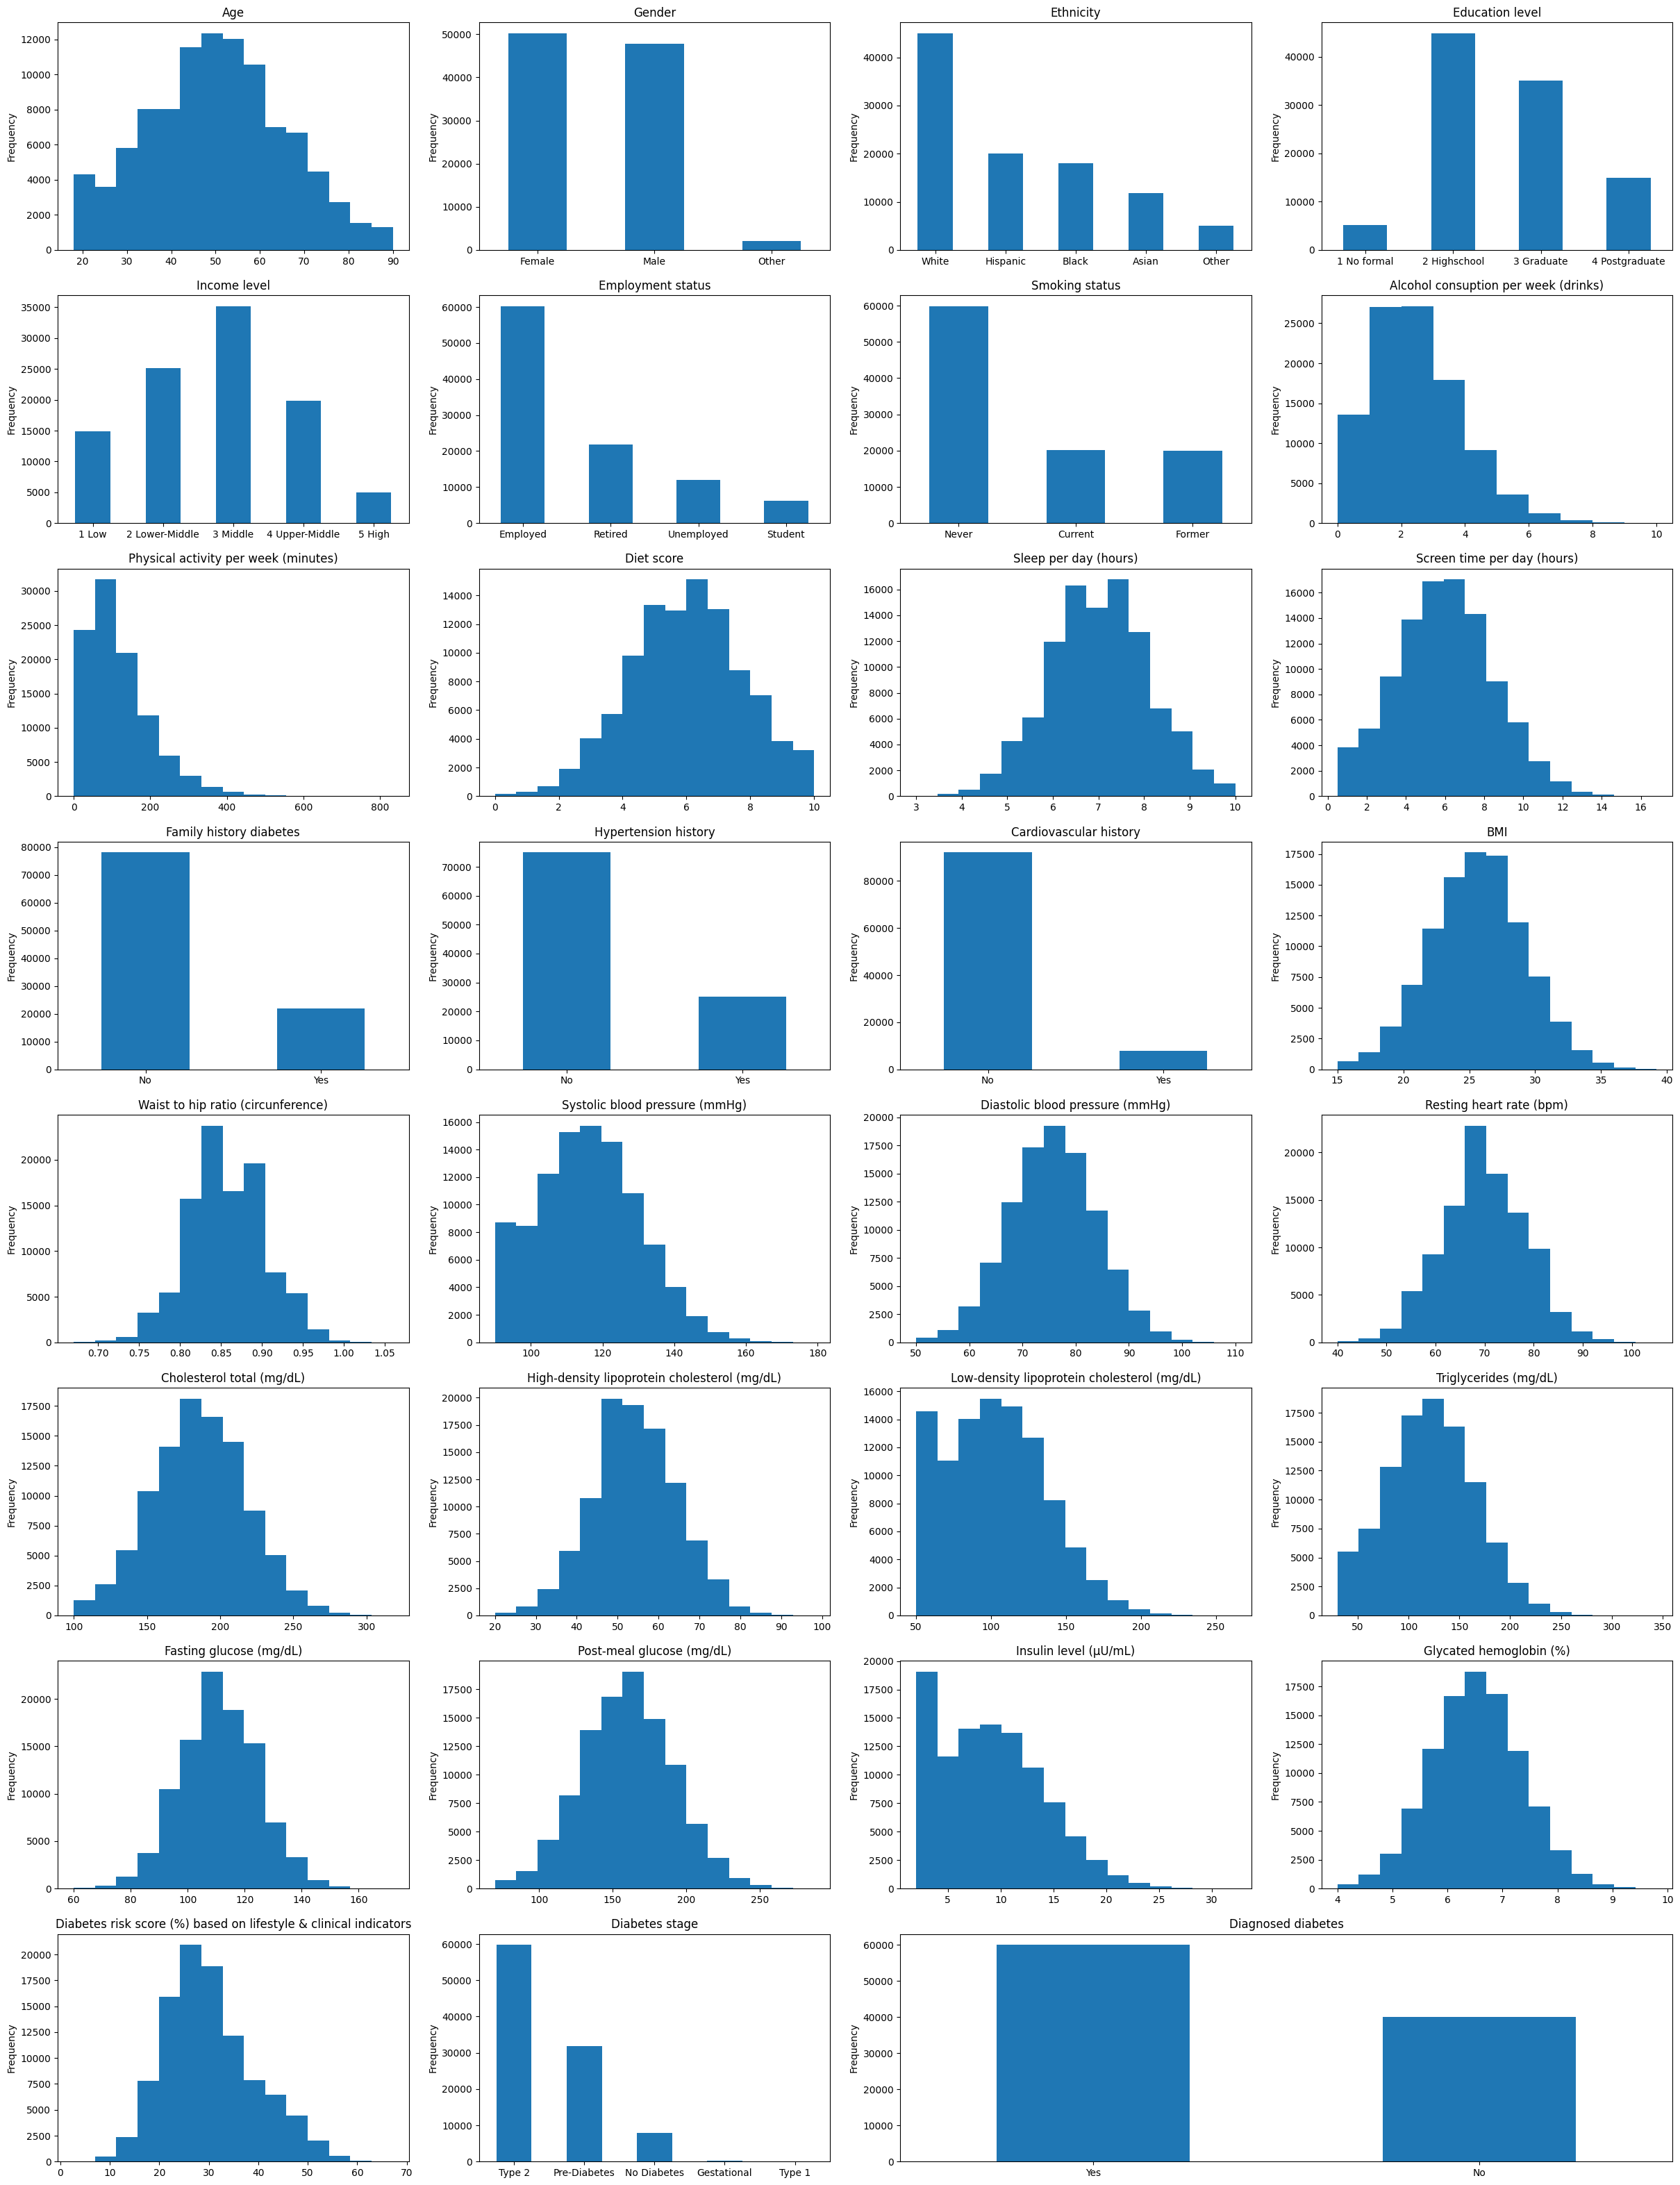

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50.12041,2.003670,118.911640,5.994787,6.997818,5.996468,25.612653,0.856078,115.799610,75.23249,69.632870,185.978110,54.042790,103.000430,121.462650,111.11712,160.035050,9.061242,6.520776,30.222362
std,15.60460,1.417779,84.409662,1.780954,1.094622,2.468406,3.586705,0.046837,14.284073,8.20425,8.371954,32.013005,10.267374,33.390256,43.372619,13.59561,30.935472,4.954060,0.813921,9.061505
min,18.00000,0.000000,0.000000,0.000000,3.000000,0.500000,15.000000,0.670000,90.000000,50.00000,40.000000,100.000000,20.000000,50.000000,30.000000,60.00000,70.000000,2.000000,4.000000,2.700000
25%,39.00000,1.000000,57.000000,4.800000,6.300000,4.300000,23.200000,0.820000,106.000000,70.00000,64.000000,164.000000,47.000000,78.000000,91.000000,102.00000,139.000000,5.090000,5.970000,23.800000
50%,50.00000,2.000000,100.000000,6.000000,7.000000,6.000000,25.600000,0.860000,116.000000,75.00000,70.000000,186.000000,54.000000,102.000000,121.000000,111.00000,160.000000,8.790000,6.520000,29.000000
75%,61.00000,3.000000,160.000000,7.200000,7.700000,7.700000,28.000000,0.890000,125.000000,81.00000,75.000000,208.000000,61.000000,126.000000,151.000000,120.00000,181.000000,12.450000,7.070000,35.600000
max,90.00000,10.000000,833.000000,10.000000,10.000000,16.800000,39.200000,1.060000,179.000000,110.00000,105.000000,318.000000,98.000000,263.000000,344.000000,172.00000,287.000000,32.220000,9.800000,67.200000


In [5]:

lines = 8

fig = plt.figure(figsize=(30, lines*5))
grid = gridspec.GridSpec(lines, 4, figure=fig)

# 1° linha
ax = fig.add_subplot(grid[0, 0])
df['age'].plot.hist(ax=ax, bins=15)
ax.set_title('Age')

ax = fig.add_subplot(grid[0, 1])
df['gender'].value_counts().plot.bar(ax=ax)
ax.set_title('Gender')
ax.set_xlabel(None)
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)

ax = fig.add_subplot(grid[0, 2])
df['ethnicity'].value_counts().plot.bar(ax=ax)
ax.set_title('Ethnicity')
ax.set_xlabel(None)
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)

ax = fig.add_subplot(grid[0, 3])
df['education_level'].value_counts().sort_index().plot.bar(ax=ax)
ax.set_title('Education level')
ax.set_xlabel(None)
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)

ax = fig.add_subplot(grid[1, 0])
df['income_level'].value_counts().sort_index().plot.bar(ax=ax)
ax.set_title('Income level')
ax.set_xlabel(None)
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)

ax = fig.add_subplot(grid[1, 1])
df['employment_status'].value_counts().plot.bar(ax=ax)
ax.set_title('Employment status')
ax.set_xlabel(None)
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)

ax = fig.add_subplot(grid[1, 2])
df['smoking_status'].value_counts().plot.bar(ax=ax)
ax.set_title('Smoking status')
ax.set_xlabel(None)
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)

ax = fig.add_subplot(grid[1, 3])
df['alcohol_consumption_per_week'].plot.hist(ax=ax, bins=10)
ax.set_title('Alcohol consuption per week (drinks)')

ax = fig.add_subplot(grid[2, 0])
df['physical_activity_minutes_per_week'].plot.hist(ax=ax, bins=15)
ax.set_title('Physical activity per week (minutes)')

ax = fig.add_subplot(grid[2, 1])
df['diet_score'].plot.hist(ax=ax, bins=15)
ax.set_title('Diet score')

ax = fig.add_subplot(grid[2, 2])
df['sleep_hours_per_day'].plot.hist(ax=ax, bins=15)
ax.set_title('Sleep per day (hours)')

ax = fig.add_subplot(grid[2, 3])
df['screen_time_hours_per_day'].plot.hist(ax=ax, bins=15)
ax.set_title('Screen time per day (hours)')

ax = fig.add_subplot(grid[3, 0])
df['family_history_diabetes'].value_counts().plot.bar(ax=ax)
ax.set_title('Family history diabetes')
ax.set_xlabel(None)
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)

ax = fig.add_subplot(grid[3, 1])
df['hypertension_history'].value_counts().plot.bar(ax=ax)
ax.set_title('Hypertension history')
ax.set_xlabel(None)
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)

ax = fig.add_subplot(grid[3, 2])
df['cardiovascular_history'].value_counts().plot.bar(ax=ax)
ax.set_title('Cardiovascular history')
ax.set_xlabel(None)
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)

ax = fig.add_subplot(grid[3, 3])
df['bmi'].plot.hist(ax=ax, bins=15)
ax.set_title('BMI')

ax = fig.add_subplot(grid[4, 0])
df['waist_to_hip_ratio'].plot.hist(ax=ax, bins=15)
ax.set_title('Waist to hip ratio (circunference)')

ax = fig.add_subplot(grid[4, 1])
df['systolic_bp'].plot.hist(ax=ax, bins=15)
ax.set_title('Systolic blood pressure (mmHg)') # fase de contração do coração -> pressão mais alta do que a fase diastolic

ax = fig.add_subplot(grid[4, 2])
df['diastolic_bp'].plot.hist(ax=ax, bins=15)
ax.set_title('Diastolic blood pressure (mmHg)') # relaxamento do coração -> pressão mais baixa do que a fase systolic

ax = fig.add_subplot(grid[4, 3])
df['heart_rate'].plot.hist(ax=ax, bins=15)
ax.set_title('Resting heart rate (bpm)')

ax = fig.add_subplot(grid[5, 0])
df['cholesterol_total'].plot.hist(ax=ax, bins=15)
ax.set_title('Cholesterol total (mg/dL)')

ax = fig.add_subplot(grid[5, 1])
df['hdl_cholesterol'].plot.hist(ax=ax, bins=15)
ax.set_title('High-density lipoprotein cholesterol (mg/dL)')

ax = fig.add_subplot(grid[5, 2])
df['ldl_cholesterol'].plot.hist(ax=ax, bins=15)
ax.set_title('Low-density lipoprotein cholesterol (mg/dL)')

ax = fig.add_subplot(grid[5, 3])
df['triglycerides'].plot.hist(ax=ax, bins=15)
ax.set_title('Triglycerides (mg/dL)')

ax = fig.add_subplot(grid[6, 0])
df['glucose_fasting'].plot.hist(ax=ax, bins=15)
ax.set_title('Fasting glucose (mg/dL)')

ax = fig.add_subplot(grid[6, 1])
df['glucose_postprandial'].plot.hist(ax=ax, bins=15)
ax.set_title('Post-meal glucose (mg/dL)')

ax = fig.add_subplot(grid[6, 2])
df['insulin_level'].plot.hist(ax=ax, bins=15)
ax.set_title('Insulin level (µU/mL)')

ax = fig.add_subplot(grid[6, 3])
df['hba1c'].plot.hist(ax=ax, bins=15)
ax.set_title('Glycated hemoglobin (%)')

ax = fig.add_subplot(grid[7, 0])
df['diabetes_risk_score'].plot.hist(ax=ax, bins=15)
ax.set_title('Diabetes risk score (%) based on lifestyle & clinical indicators')

ax = fig.add_subplot(grid[7, 1])
df['diabetes_stage'].value_counts().plot.bar(ax=ax)
ax.set_title('Diabetes stage')
ax.set_xlabel(None)
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)

ax = fig.add_subplot(grid[7, 2:])
df['diagnosed_diabetes'].value_counts().plot.bar(ax=ax)
ax.set_title('Diagnosed diabetes')
ax.set_xlabel(None)
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)

plt.show()

display(df.describe())

**Observações:**

Distribuições balanceadas no geral. <br>
'Glycated hemoglobin' é o marcador diagnostico para Diabetes, muito provavelemente é uma ótima preditora. Se ela sozinha for capaz de classificar corretamente Diabetes então não trabalharemos com ela, pois podemos ver ela seja uma "vazadora" da target. <br>
'Diabetes stage' é uma variavel target e será removida da analise pois só trabalharemos com a target 'Diagnosed diabetes' <br>

In [6]:
df = df.drop('diabetes_stage', axis=1)

#### *Bivariate* Analysis ~ versus *diagnosed_diabetes*

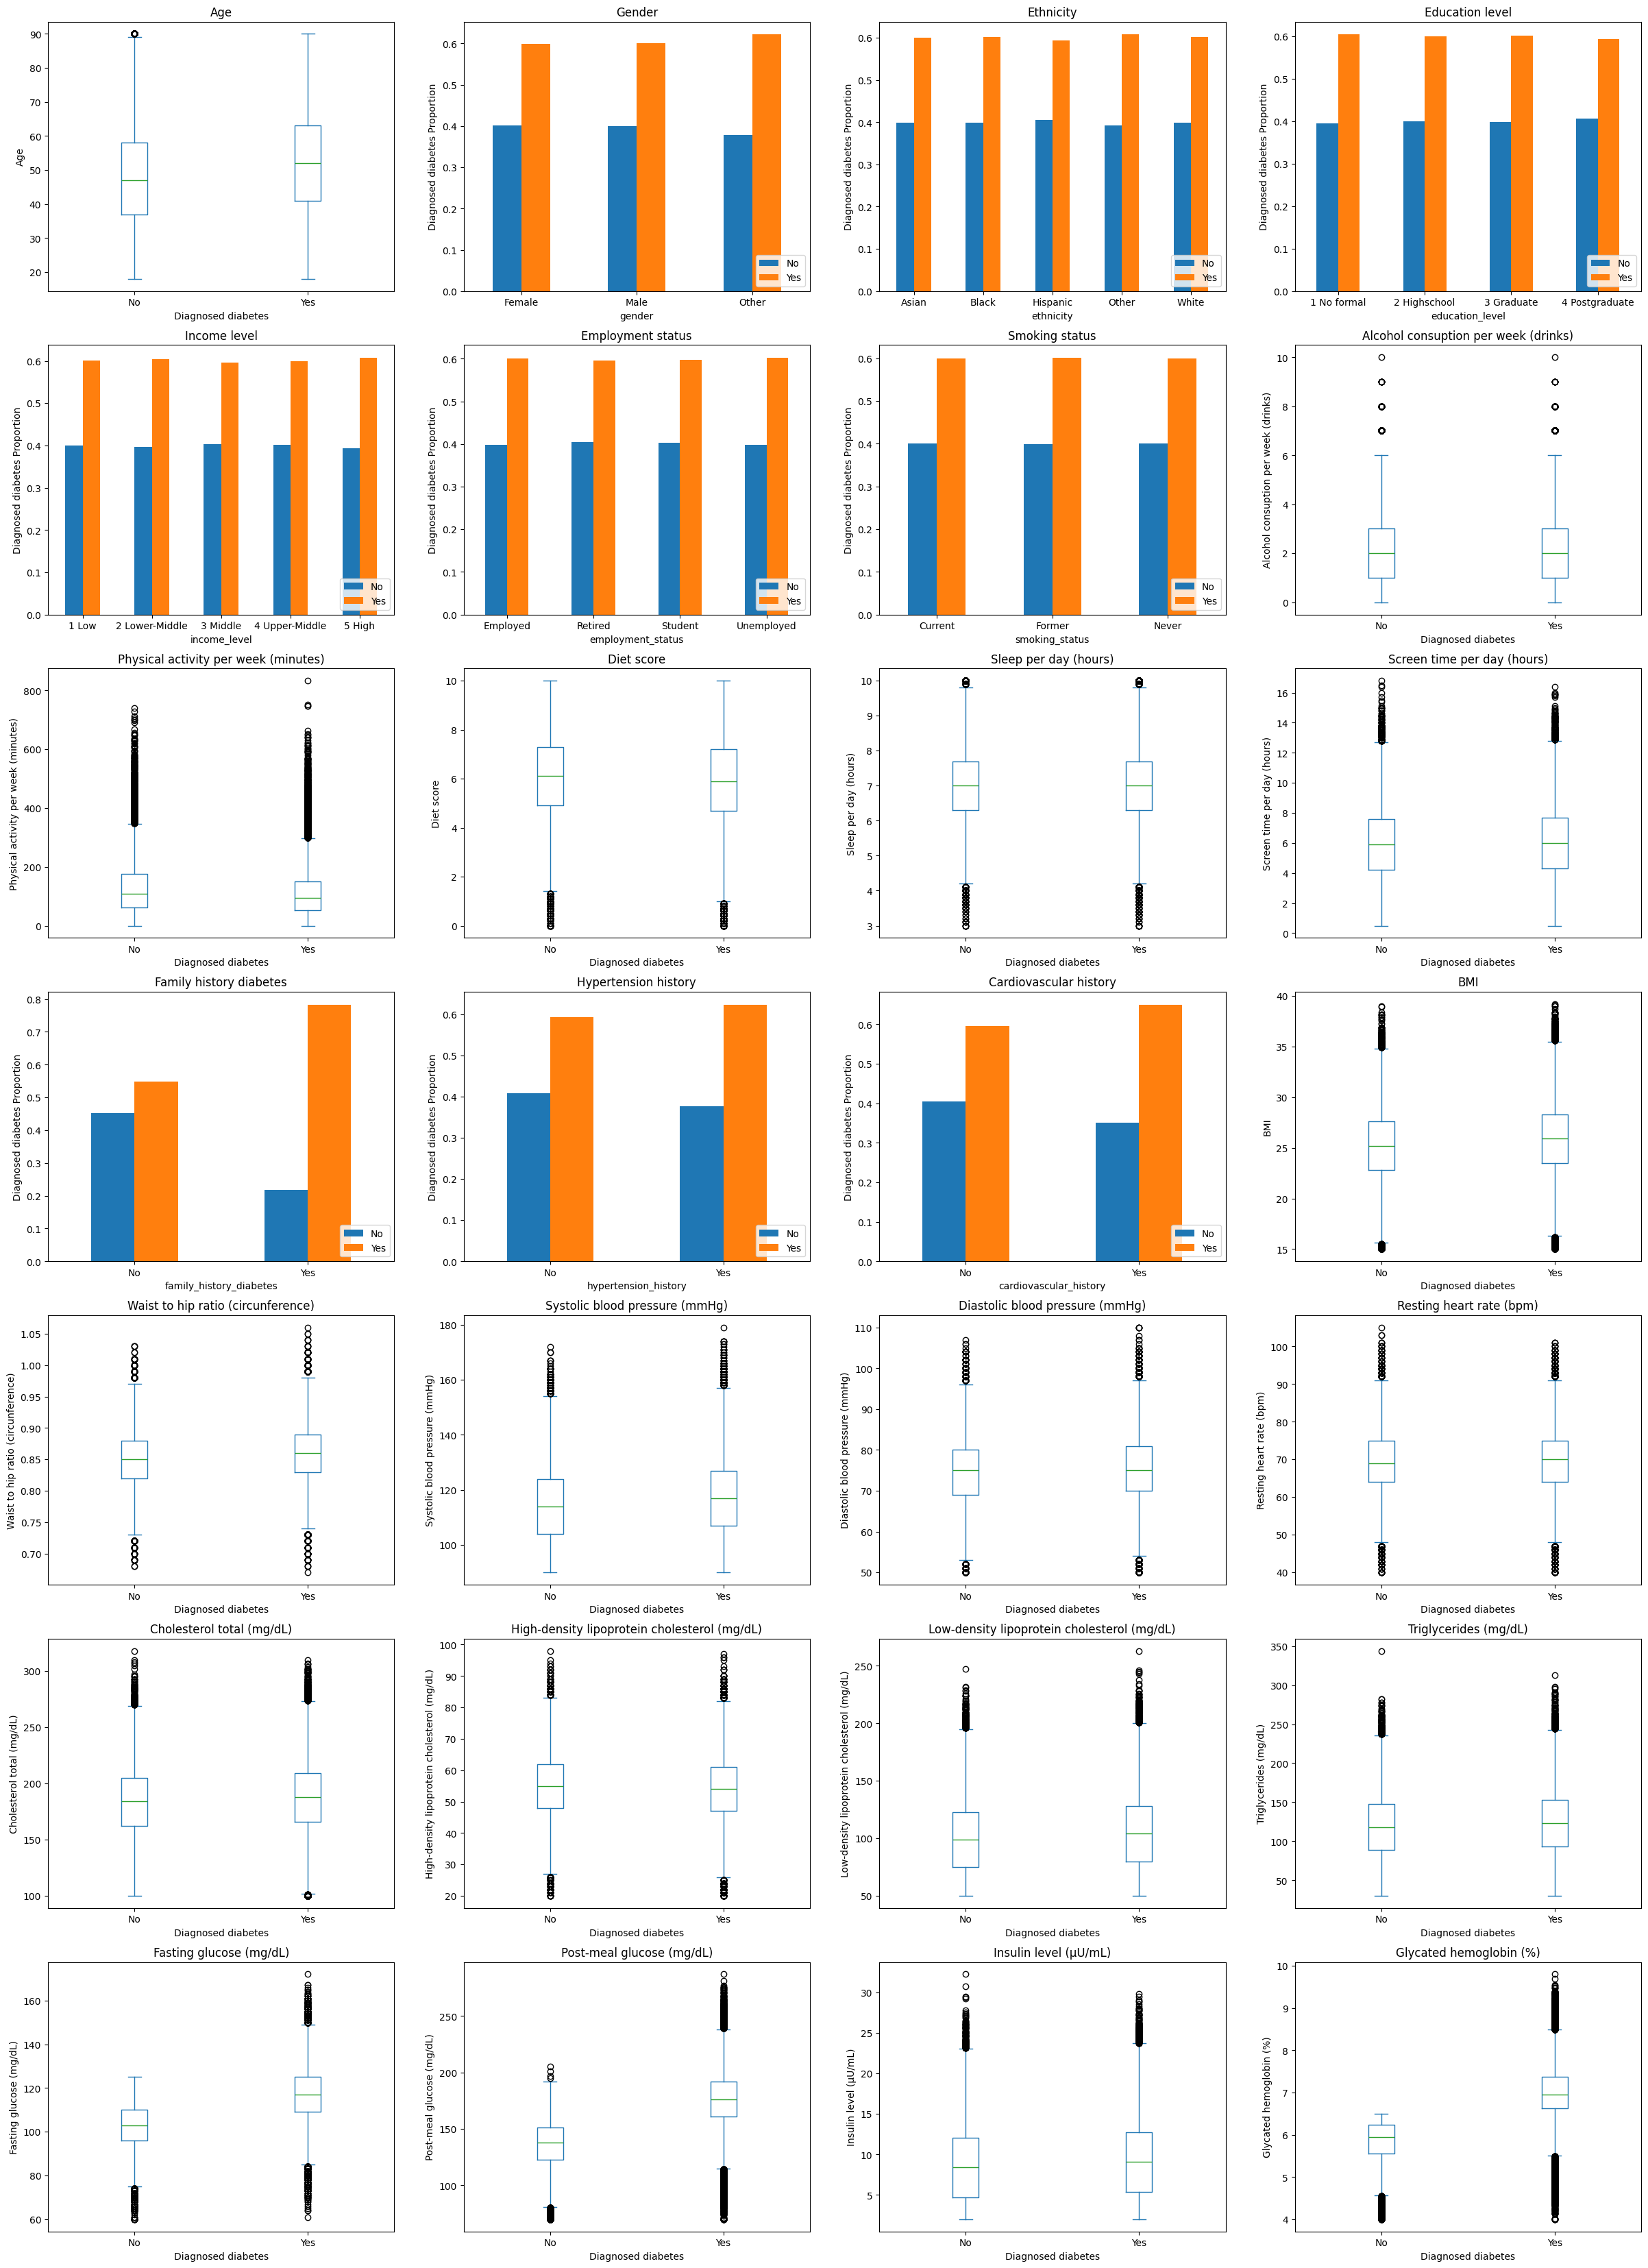

In [7]:

fig = plt.figure(figsize=(30, lines*6))
grid = gridspec.GridSpec(lines, 4, figure=fig)

ax = fig.add_subplot(grid[0, 0])
df[['age','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Age')
ax.set_ylabel('Age')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[0, 1])
df_ = df.groupby('gender')['diagnosed_diabetes'].value_counts(normalize=True).reset_index()
df_.pivot_table(index='gender', columns='diagnosed_diabetes', values='proportion').plot.bar(rot=0, ax=ax)
ax.set_title('Gender')
ax.set_ylabel('Diagnosed diabetes Proportion')
ax.legend(loc='lower right')

ax = fig.add_subplot(grid[0, 2])
df_ = df.groupby('ethnicity')['diagnosed_diabetes'].value_counts(normalize=True).reset_index()
df_.pivot_table(index='ethnicity', columns='diagnosed_diabetes', values='proportion').plot.bar(rot=0, ax=ax)
ax.set_title('Ethnicity')
ax.set_ylabel('Diagnosed diabetes Proportion')
ax.legend(loc='lower right')

ax = fig.add_subplot(grid[0, 3])
df_ = df.groupby('education_level')['diagnosed_diabetes'].value_counts(normalize=True).reset_index()
df_.pivot_table(index='education_level', columns='diagnosed_diabetes', values='proportion').plot.bar(rot=0, ax=ax)
ax.set_title('Education level')
ax.set_ylabel('Diagnosed diabetes Proportion')
ax.legend(loc='lower right')

ax = fig.add_subplot(grid[1, 0])
df_ = df.groupby('income_level')['diagnosed_diabetes'].value_counts(normalize=True).reset_index()
df_.pivot_table(index='income_level', columns='diagnosed_diabetes', values='proportion').plot.bar(rot=0, ax=ax)
ax.set_title('Income level')
ax.set_ylabel('Diagnosed diabetes Proportion')
ax.legend(loc='lower right')

ax = fig.add_subplot(grid[1, 1])
df_ = df.groupby('employment_status')['diagnosed_diabetes'].value_counts(normalize=True).reset_index()
df_.pivot_table(index='employment_status', columns='diagnosed_diabetes', values='proportion').plot.bar(rot=0, ax=ax)
ax.set_title('Employment status')
ax.set_ylabel('Diagnosed diabetes Proportion')
ax.legend(loc='lower right')

ax = fig.add_subplot(grid[1, 2])
df_ = df.groupby('smoking_status')['diagnosed_diabetes'].value_counts(normalize=True).reset_index()
df_.pivot_table(index='smoking_status', columns='diagnosed_diabetes', values='proportion').plot.bar(rot=0, ax=ax)
ax.set_title('Smoking status')
ax.set_ylabel('Diagnosed diabetes Proportion')
ax.legend(loc='lower right')

ax = fig.add_subplot(grid[1, 3])
df[['alcohol_consumption_per_week','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Alcohol consuption per week (drinks)')
ax.set_ylabel('Alcohol consuption per week (drinks)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[2, 0])
df[['physical_activity_minutes_per_week','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Physical activity per week (minutes)')
ax.set_ylabel('Physical activity per week (minutes)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[2, 1])
df[['diet_score','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Diet score')
ax.set_ylabel('Diet score')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[2, 2])
df[['sleep_hours_per_day','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Sleep per day (hours)')
ax.set_ylabel('Sleep per day (hours)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[2, 3])
df[['screen_time_hours_per_day','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Screen time per day (hours)')
ax.set_ylabel('Screen time per day (hours)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[3, 0])
df_ = df.groupby('family_history_diabetes')['diagnosed_diabetes'].value_counts(normalize=True).reset_index()
df_.pivot_table(index='family_history_diabetes', columns='diagnosed_diabetes', values='proportion').plot.bar(rot=0, ax=ax)
ax.set_title('Family history diabetes')
ax.set_ylabel('Diagnosed diabetes Proportion')
ax.legend(loc='lower right')

ax = fig.add_subplot(grid[3, 1])
df_ = df.groupby('hypertension_history')['diagnosed_diabetes'].value_counts(normalize=True).reset_index()
df_.pivot_table(index='hypertension_history', columns='diagnosed_diabetes', values='proportion').plot.bar(rot=0, ax=ax)
ax.set_title('Hypertension history')
ax.set_ylabel('Diagnosed diabetes Proportion')
ax.legend(loc='lower right')

ax = fig.add_subplot(grid[3, 2])
df_ = df.groupby('cardiovascular_history')['diagnosed_diabetes'].value_counts(normalize=True).reset_index()
df_.pivot_table(index='cardiovascular_history', columns='diagnosed_diabetes', values='proportion').plot.bar(rot=0, ax=ax)
ax.set_title('Cardiovascular history')
ax.set_ylabel('Diagnosed diabetes Proportion')
ax.legend(loc='lower right')

ax = fig.add_subplot(grid[3, 3])
df[['bmi','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('BMI')
ax.set_ylabel('BMI')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[4, 0])
df[['waist_to_hip_ratio','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Waist to hip ratio (circunference)')
ax.set_ylabel('Waist to hip ratio (circunference)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[4, 1])
df[['systolic_bp','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Systolic blood pressure (mmHg)')
ax.set_ylabel('Systolic blood pressure (mmHg)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[4, 2])
df[['diastolic_bp','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Diastolic blood pressure (mmHg)')
ax.set_ylabel('Diastolic blood pressure (mmHg)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[4, 3])
df[['heart_rate','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Resting heart rate (bpm)')
ax.set_ylabel('Resting heart rate (bpm)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[5, 0])
df[['cholesterol_total','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Cholesterol total (mg/dL)')
ax.set_ylabel('Cholesterol total (mg/dL)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[5, 1])
df[['hdl_cholesterol','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('High-density lipoprotein cholesterol (mg/dL)')
ax.set_ylabel('High-density lipoprotein cholesterol (mg/dL)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[5, 2])
df[['ldl_cholesterol','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Low-density lipoprotein cholesterol (mg/dL)')
ax.set_ylabel('Low-density lipoprotein cholesterol (mg/dL)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[5, 3])
df[['triglycerides','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Triglycerides (mg/dL)')
ax.set_ylabel('Triglycerides (mg/dL)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[6, 0])
df[['glucose_fasting','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Fasting glucose (mg/dL)')
ax.set_ylabel('Fasting glucose (mg/dL)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[6, 1])
df[['glucose_postprandial','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Post-meal glucose (mg/dL)')
ax.set_ylabel('Post-meal glucose (mg/dL)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[6, 2])
df[['insulin_level','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Insulin level (µU/mL)')
ax.set_ylabel('Insulin level (µU/mL)')
ax.set_xlabel('Diagnosed diabetes')

ax = fig.add_subplot(grid[6, 3])
df[['hba1c','diagnosed_diabetes']].plot.box(by='diagnosed_diabetes', ax=ax)
ax.set_title('Glycated hemoglobin (%)')
ax.set_ylabel('Glycated hemoglobin (%)')
ax.set_xlabel('Diagnosed diabetes')

plt.show()

**Observações.:** 

'Glycated hemoglobin' não é regra exata para classifação de Diabete, logo ela não vaza a target, continuaremos com ela como feature. <br>

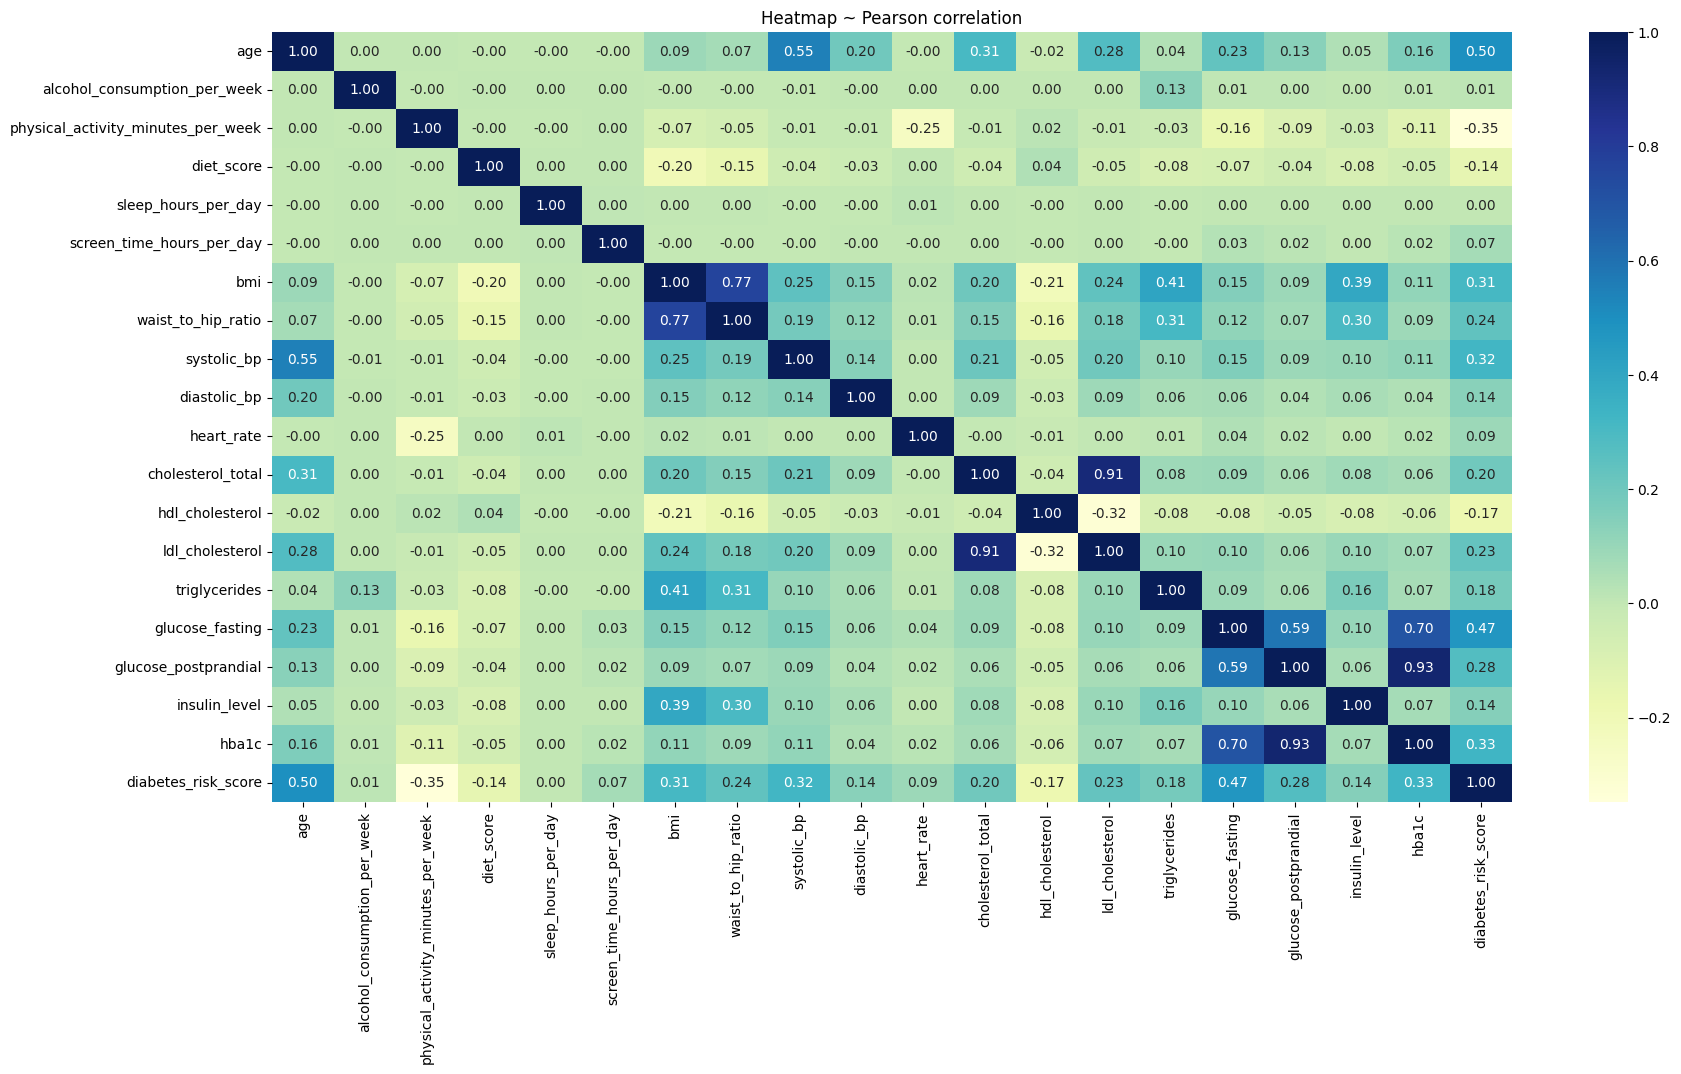

In [8]:
plt.figure(figsize=(20, 10)) # Optional: Adjust figure size
df_corr = df[[
    'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 
    'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c', 'diabetes_risk_score'
    ]].corr()
sns.heatmap(df_corr, annot=True, cmap='YlGnBu', fmt='.2f') # Add annotations and specific colormap
plt.title('Heatmap ~ Pearson correlation')
plt.show()

In [9]:

# Testes de hipoteses
a = .05

categ_cols = ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
numeric_cols = ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 
                'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c']
statistic_associated_cols = []
for col in [col for col in df.columns if col != 'diagnosed_diabetes']:
    print()
    print(f'-- {col}')
    if col in numeric_cols:
        equal_var = True

        display(df.groupby('diagnosed_diabetes')[col].mean())
        # teste de hip para variancia (2) ~ h0: variancias iguais, ha: variancias diferentes
        x1, x2 = df[df['diagnosed_diabetes']=='Yes'][col], df[df['diagnosed_diabetes']=='No'][col]
        stat = np.var(x1, ddof=1)/np.var(x2, ddof=1)
        df1, df2 = len(x1) - 1, len(x2) - 1
        p = 2*min(f.cdf(stat, df1, df2), 1-f.cdf(stat, df1, df2))
        print(f'F) p-value: {p}')
        if p <= a: 
            print(f'- existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: variancias diferentes.')
            equal_var = False
        else: 
            print(f'- não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: variancias iguais.')

        # teste de hip para media (2), var diferentes ou iguais (<equal_var>) ~ h0: variancias iguais, ha: variancias diferentes
        stat, p = ttest_ind(x1, x2, equal_var=equal_var)
        print(f'T) p-value: {p}')
        if p <= a: 
            print(f'* existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: medias diferentes.')
            statistic_associated_cols.append(col)
        else: print(f'- não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: medias iguais.')

    elif col in categ_cols: # teste de hip para categorias (2) ~ h0: categorias não dependentes, ha: categorias dependentes
        df_ = pd.crosstab(df[col], df['diagnosed_diabetes'])
        display(pd.crosstab(df[col], df['diagnosed_diabetes']))
        stats, p, _, _ = chi2_contingency(df_)
        print(stats, p)
        print(f'X²) p-value: {p}')
        if p <= a: 
            print(f'-* existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: categorias dependentes.')
            statistic_associated_cols.append(col)
        else: print(f'- não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: categorias não dependentes.')

print('\n')
print('colunas associadas estatisticamente significantes:')
display(statistic_associated_cols)
print(f'{round(len(statistic_associated_cols)/(df.shape[1]-1), 2)} das colunas do dataset possuem associações estatisticamente significantes (via analise bivariada)')


-- age


diagnosed_diabetes
No     47.488601
Yes    51.875096
Name: age, dtype: float64

F) p-value: 0.0027146781155442667
- existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias diferentes.
T) p-value: 0.0
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- gender


diagnosed_diabetes,No,Yes
gender,,
Female,20164,30052
Male,19077,28694
Other,761,1252


4.6292067375610335 0.09880536552392974
X²) p-value: 0.09880536552392974
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: categorias não dependentes.

-- ethnicity


diagnosed_diabetes,No,Yes
ethnicity,,
Asian,4737,7128
Black,7169,10817
Hispanic,8163,11940
Other,1981,3068
White,17952,27045


4.684895617166723 0.32118294592539454
X²) p-value: 0.32118294592539454
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: categorias não dependentes.

-- education_level


diagnosed_diabetes,No,Yes
education_level,,
1 No formal,2017,3083
2 Highschool,17926,26965
3 Graduate,13973,21064
4 Postgraduate,6086,8886


3.354838256579342 0.3400828191688993
X²) p-value: 0.3400828191688993
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: categorias não dependentes.

-- income_level


diagnosed_diabetes,No,Yes
income_level,,
1 Low,5924,8906
2 Lower-Middle,9963,15187
3 Middle,14177,20975
4 Upper-Middle,7973,11893
5 High,1965,3037


4.393047063592936 0.3554183584482454
X²) p-value: 0.3554183584482454
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: categorias não dependentes.

-- employment_status


diagnosed_diabetes,No,Yes
employment_status,,
Employed,23979,36196
Retired,8807,12954
Student,2475,3671
Unemployed,4741,7177


3.0155838272502806 0.38922869181679415
X²) p-value: 0.38922869181679415
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: categorias não dependentes.

-- smoking_status


diagnosed_diabetes,No,Yes
smoking_status,,
Current,8069,12107
Former,7982,12029
Never,23951,35862


0.15108097685042612 0.927242187198018
X²) p-value: 0.927242187198018
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: categorias não dependentes.

-- alcohol_consumption_per_week


diagnosed_diabetes
No     2.00235
Yes    2.00455
Name: alcohol_consumption_per_week, dtype: float64

F) p-value: 0.49675988686545475
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias iguais.
T) p-value: 0.8100034748287792
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias iguais.

-- physical_activity_minutes_per_week


diagnosed_diabetes
No     129.329184
Yes    111.966032
Name: physical_activity_minutes_per_week, dtype: float64

F) p-value: 1.8260357210966378e-156
- existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias diferentes.
T) p-value: 2.514603357094607e-213
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- diet_score


diagnosed_diabetes
No     6.091405
Yes    5.930369
Name: diet_score, dtype: float64

F) p-value: 0.992068325880674
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias iguais.
T) p-value: 1.2639736695873865e-44
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- sleep_hours_per_day


diagnosed_diabetes
No     6.998353
Yes    6.997462
Name: sleep_hours_per_day, dtype: float64

F) p-value: 0.4600524950321958
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias iguais.
T) p-value: 0.899651747701555
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias iguais.

-- screen_time_hours_per_day


diagnosed_diabetes
No     5.941670
Yes    6.033003
Name: screen_time_hours_per_day, dtype: float64

F) p-value: 0.8279548611003855
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias iguais.
T) p-value: 9.891767762923527e-09
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- family_history_diabetes


diagnosed_diabetes,No,Yes
family_history_diabetes,,
No,35238,42821
Yes,4764,17177


3916.492682527949 0.0
X²) p-value: 0.0
-* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: categorias dependentes.

-- hypertension_history


diagnosed_diabetes,No,Yes
hypertension_history,,
No,30554,44366
Yes,9448,15632


75.62829226948362 3.4241983471994062e-18
X²) p-value: 3.4241983471994062e-18
-* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: categorias dependentes.

-- cardiovascular_history


diagnosed_diabetes,No,Yes
cardiovascular_history,,
No,37228,54852
Yes,2774,5146


88.53807485604537 4.986577016347968e-21
X²) p-value: 4.986577016347968e-21
-* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: categorias dependentes.

-- bmi


diagnosed_diabetes
No     25.186321
Yes    25.896898
Name: bmi, dtype: float64

F) p-value: 0.36693206246084564
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias iguais.
T) p-value: 7.84528560184531e-208
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- waist_to_hip_ratio


diagnosed_diabetes
No     0.851551
Yes    0.859096
Name: waist_to_hip_ratio, dtype: float64

F) p-value: 0.17669937095224558
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias iguais.
T) p-value: 6.964579613092261e-138
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- systolic_bp


diagnosed_diabetes
No     114.129319
Yes    116.913230
Name: systolic_bp, dtype: float64

F) p-value: 1.220702640747362e-06
- existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias diferentes.
T) p-value: 8.454800340091522e-203
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- diastolic_bp


diagnosed_diabetes
No     74.874606
Yes    75.471099
Name: diastolic_bp, dtype: float64

F) p-value: 0.3932025836726989
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias iguais.
T) p-value: 1.9086349776030037e-29
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- heart_rate


diagnosed_diabetes
No     69.399255
Yes    69.788626
Name: heart_rate, dtype: float64

F) p-value: 0.284854900435921
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias iguais.
T) p-value: 5.758310475977434e-13
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- cholesterol_total


diagnosed_diabetes
No     183.697365
Yes    187.498733
Name: cholesterol_total, dtype: float64

F) p-value: 0.043110332307703336
- existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias diferentes.
T) p-value: 5.94475010488546e-76
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- hdl_cholesterol


diagnosed_diabetes
No     54.686941
Yes    53.613320
Name: hdl_cholesterol, dtype: float64

F) p-value: 1.1807973199662314e-05
- existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias diferentes.
T) p-value: 1.5269696885754194e-59
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- ldl_cholesterol


diagnosed_diabetes
No     100.241213
Yes    104.840061
Name: ldl_cholesterol, dtype: float64

F) p-value: 5.300533515661954e-06
- existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias diferentes.
T) p-value: 4.912829956006915e-102
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- triglycerides


diagnosed_diabetes
No     118.475826
Yes    123.454032
Name: triglycerides, dtype: float64

F) p-value: 0.08402876386951408
- não existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias iguais.
T) p-value: 7.676517648718946e-71
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- glucose_fasting


diagnosed_diabetes
No     102.610119
Yes    116.788926
Name: glucose_fasting, dtype: float64

F) p-value: 2.220446049250313e-16
- existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias diferentes.
T) p-value: 0.0
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- glucose_postprandial


diagnosed_diabetes
No     136.173041
Yes    175.944381
Name: glucose_postprandial, dtype: float64

F) p-value: 2.220446049250313e-16
- existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias diferentes.
T) p-value: 0.0
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- insulin_level


diagnosed_diabetes
No     8.711073
Yes    9.294708
Name: insulin_level, dtype: float64

F) p-value: 1.666084181772831e-05
- existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias diferentes.
T) p-value: 4.287760284947945e-75
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- hba1c


diagnosed_diabetes
No     5.843554
Yes    6.972295
Name: hba1c, dtype: float64

F) p-value: 2.220446049250313e-16
- existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: variancias diferentes.
T) p-value: 0.0
* existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: medias diferentes.

-- diabetes_risk_score


colunas associadas estatisticamente significantes:


['age',
 'physical_activity_minutes_per_week',
 'diet_score',
 'screen_time_hours_per_day',
 'family_history_diabetes',
 'hypertension_history',
 'cardiovascular_history',
 'bmi',
 'waist_to_hip_ratio',
 'systolic_bp',
 'diastolic_bp',
 'heart_rate',
 'cholesterol_total',
 'hdl_cholesterol',
 'ldl_cholesterol',
 'triglycerides',
 'glucose_fasting',
 'glucose_postprandial',
 'insulin_level',
 'hba1c']

0.69 das colunas do dataset possuem associações estatisticamente significantes (via analise bivariada)


#### *Multivariate* Analysis ~ versus *diagnosed_diabetes*

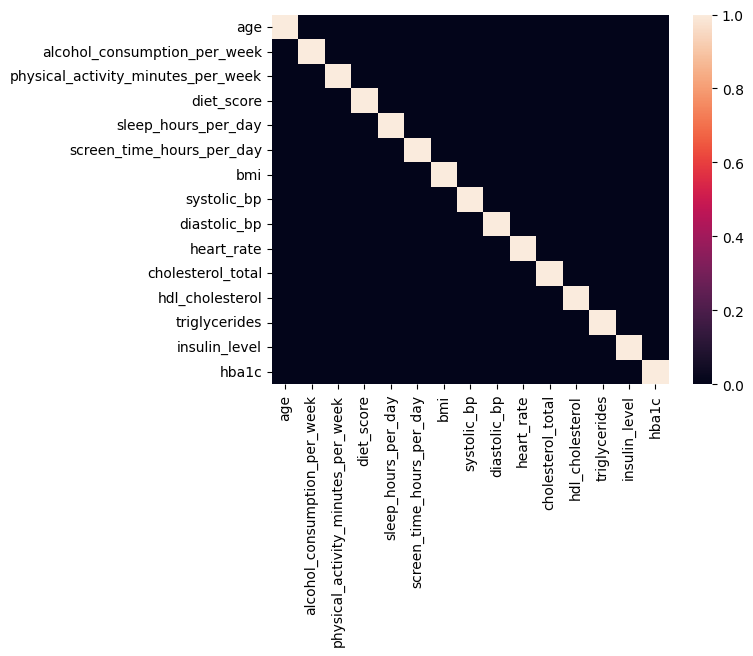

In [10]:
# PIPELINE (parte2.1)
df_rl = df.drop(['diabetes_risk_score'], axis=1)
df_rl.columns = [col.replace(' ', '_') for col in df_rl.columns]

# multicolinearidade
sns.heatmap((df_rl[[
    'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'systolic_bp', 'diastolic_bp', 
    'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'triglycerides', 'insulin_level', 'hba1c',
    ]].corr().abs() > .7).astype(int))

df_rl = df_rl.drop([  ## colunas colineares, remove                            
    'waist_to_hip_ratio', 'glucose_postprandial', 'ldl_cholesterol', 'glucose_fasting'
    ], axis=1)      

In [11]:

# colunas ordinais (removendo numero de ordem por facilicar a leitura ~ não afetou o R² do modelo)
for col in ['education_level', 'income_level']:
    df_rl[col] = df_rl[col].apply(lambda x: ' '.join(x.split()[1:]))

print('dummies')
dummies = []
# classic categ dummies
dummies_cols = ['gender', 'ethnicity', 'employment_status', 'smoking_status', 'education_level', 'income_level']
dummies += dummies_cols
default_dimmies_cols = []
for col in dummies_cols:
    print(f"default for {col}: {df_rl[col].unique()[0]}")
    for i, val in enumerate(df_rl[col].unique()):
        col_name = f"{col}_{val.replace(' ','_').replace('-','_')}_"
        df_rl[col_name] = (df_rl[col] == val).astype(int)
        if i == 0: default_dimmies_cols.append(col_name)
    df_rl = df_rl.drop(col, axis=1)
df_rl = df_rl.drop(default_dimmies_cols, axis=1) # deletando colunas redundantes
# yes or no dummies
dummies_cols = ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']
dummies += dummies_cols
for col in dummies_cols:
    df_rl[col] = (df_rl[col]=='Yes').astype(int)

# padronizando valores
# scaler = StandardScaler()
# df_rl_values = scaler.fit_transform(df_rl)
# df_rl = pd.DataFrame(df_rl_values, columns=df_rl.columns)

# train/test split
df_test = df_rl.sample(int(df_rl.shape[0]*.25), random_state=42)
df_rl = df_rl.loc[[i for i in df_rl.index if i not in df_test.index]]
print(f'\ntest: {df_test.shape[0]/(df_test.shape[0]+df_rl.shape[0])}, train: {df_rl.shape[0]/(df_test.shape[0]+df_rl.shape[0])}')

target = 'diagnosed_diabetes'
features = [col for col in df_rl.columns if target not in col]

print()
print('random train example:')
display(df_rl.sample().iloc[0])

dummies
default for gender: Male
default for ethnicity: Asian
default for employment_status: Employed
default for smoking_status: Never
default for education_level: Highschool
default for income_level: Lower-Middle

test: 0.25, train: 0.75

random train example:


age                                    38.00
alcohol_consumption_per_week            4.00
physical_activity_minutes_per_week     73.00
diet_score                              6.80
sleep_hours_per_day                     7.40
screen_time_hours_per_day               8.30
family_history_diabetes                 1.00
hypertension_history                    0.00
cardiovascular_history                  0.00
bmi                                    32.20
systolic_bp                           115.00
diastolic_bp                           69.00
heart_rate                             65.00
cholesterol_total                     216.00
hdl_cholesterol                        32.00
triglycerides                         130.00
insulin_level                          14.71
hba1c                                   6.98
diagnosed_diabetes                      1.00
gender_Female_                          1.00
gender_Other_                           0.00
ethnicity_White_                        0.00
ethnicity_

In [12]:

formula = f"{target} ~ {' + '.join(features)}"
model = smf.glm(formula=formula, data=df_rl, family=sm.families.Binomial()) 
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     diagnosed_diabetes   No. Observations:                75000
Model:                            GLM   Df Residuals:                    74963
Model Family:                Binomial   Df Model:                           36
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26082.
Date:                Mon, 15 Dec 2025   Deviance:                       52164.
Time:                        01:52:30   Pearson chi2:                 2.25e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4778
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            -22.9507      0.277    -82.913      0.000     -23.493     -22.408
age                                    0.0084      0.001      9.260      0.000       0.007       0.010
alcohol_consumption_per_week          -0.0081      0.008     -1.037      0.300      -0.024       0.007
physical_activity_minutes_per_week    -0.0012      0.000     -9.214      0.000      -0.002      -0.001
diet_score                            -0.0133      0.006     -2.108      0.035      -0.026      -0.001
sleep_hours_per_day                    0.0016      0.010      0.164      0.870      -0.018       0.021
screen_time_hours_per_day              0.0014      0.004      0.326      0.744      -0.007       0.010
family_history_diabetes                0.4785      0.029     16.441      0.000       0.422       0.536
hypertension_history                  -0.0015      0.026     -0.058      0.954      -0.052       0.049
cardiovascular_history                 0.0226      0.042      0.540      0.589      -0.059       0.105
bmi                                    0.0186      0.004      4.793      0.000       0.011       0.026
systolic_bp                            0.0006      0.001      0.642      0.521      -0.001       0.002
diastolic_bp                          -0.0017      0.001     -1.252      0.211      -0.004       0.001
heart_rate                            -0.0012      0.001     -0.883      0.377      -0.004       0.001
cholesterol_total                      0.0004      0.000      1.059      0.290      -0.000       0.001
hdl_cholesterol                       -0.0039      0.001     -3.569      0.000      -0.006      -0.002
triglycerides                          0.0006      0.000      2.142      0.032    5.12e-05       0.001
insulin_level                         -0.0009      0.002     -0.382      0.702      -0.006       0.004
hba1c                                  3.5734      0.027    131.835      0.000       3.520       3.627
gender_Female_                         0.0056      0.022      0.251      0.802      -0.038       0.049
gender_Other_                          0.2184      0.083      2.643      0.008       0.056       0.380
ethnicity_White_                      -0.0284      0.036     -0.792      0.428      -0.099       0.042
ethnicity_Hispanic_                    0.0077      0.040      0.191      0.849      -0.071       0.087
ethnicity_Black_                      -0.0118      0.041     -0.285      0.775      -0.093       0.069
ethnicity_Other_                       0.0322      0.059      0.545      0.586      -0.084       0.148
employment_status_Unemployed_          0.0191      0.035      0.547      0.584      -0.049       0.087
employment_status_Retired_            -0.0334      0.027     -1.218      0.223      -0.087      

**insights:**

sob variaveis estatisticamente significantes:
- quanto maior o valor, maior a probabilidade de diabetes: age, family_history_diabetes, bmi, triglycerides, hba1c, gender_Other_.
- quanto maior o valor, menor a probabilidade de diabetes: diet_score, hdl_cholesterol, education_level_Postgraduate_.

variaveis que parecem ser afetadas por variaveis de confusão: hdl_cholesterol. <br>
variaveis peculiares: gender_Other_, education_level_Postgraduate_. qual será as variaveis ocultas sobre elas?

### **Predictive Model**

In [13]:
# PIPELINE (parte2.1)
df_rl = df.drop(['diabetes_risk_score'], axis=1)
df_rl.columns = [col.replace(' ', '_') for col in df_rl.columns]

for col in ['education_level', 'income_level']:
    df_rl[col] = df_rl[col].apply(lambda x: ' '.join(x.split()[1:]))

print('dummies')
dummies = []
# classic categ dummies
dummies_cols = ['gender', 'ethnicity', 'employment_status', 'smoking_status', 'education_level', 'income_level']
dummies += dummies_cols
default_dimmies_cols = []
for col in dummies_cols:
    print(f"default for {col}: {df_rl[col].unique()[0]}")
    for i, val in enumerate(df_rl[col].unique()):
        col_name = f"{col}_{val.replace(' ','_').replace('-','_')}_"
        df_rl[col_name] = (df_rl[col] == val).astype(int)
        if i == 0: default_dimmies_cols.append(col_name)
    df_rl = df_rl.drop(col, axis=1)
df_rl = df_rl.drop(default_dimmies_cols, axis=1) # deletando colunas redundantes
# yes or no dummies
dummies_cols = ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']
dummies += dummies_cols
for col in dummies_cols:
    df_rl[col] = (df_rl[col]=='Yes').astype(int)

## dataframe para numpy array
df_rl_fullset = df_rl.copy()

target = 'diagnosed_diabetes'
features = df_rl_fullset.drop(target, axis=1).columns

# train: treinamento do modelo
# cross-valid: escolha de hyperparametros e modelo
# test: insight do score/erro
X, y = df_rl_fullset[features].values, df_rl_fullset[target].values
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=.30, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_cv, y_cv, test_size=1/6, random_state=42)

print()
print('- train')
print(f'features shape: {X_train.shape} ({X_train.shape[0]/X.shape[0]}), target shape: {y_train.shape}')
print('- cross-valid')
print(f'features shape: {X_cv.shape} ({X_cv.shape[0]/X.shape[0]}), target shape: {y_cv.shape}')
print('- test')
print(f'features shape: {X_test.shape} ({X_test.shape[0]/X.shape[0]}), target shape: {y_test.shape}')

print()
print('random train example:')
display(X_train[0, :], y_train[0])

dummies
default for gender: Male
default for ethnicity: Asian
default for employment_status: Employed
default for smoking_status: Never
default for education_level: Highschool
default for income_level: Lower-Middle

- train
features shape: (70000, 40) (0.7), target shape: (70000,)
- cross-valid
features shape: (25000, 40) (0.25), target shape: (25000,)
- test
features shape: (5000, 40) (0.05), target shape: (5000,)

random train example:


array([ 43.  ,   3.  ,  38.  ,   5.2 ,   7.3 ,   9.8 ,   0.  ,   0.  ,
         0.  ,  29.9 ,   0.89, 114.  ,  68.  ,  64.  , 210.  ,  56.  ,
       138.  , 142.  , 103.  , 184.  ,   7.09,   6.99,   0.  ,   0.  ,
         0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ])

np.int64(1)

In [14]:
# transformador completo (é parte do PIPELINE, porem não esta na celula anterior por sera testado transformações diferentes)
def transform_train_set(X_train, exp):
    '''
        1. recebe os dados de entrada de treino (features)
        2. aplica transformações (feature engineering polinomios e padronização z-score)
        3. retorna os dados de entrada transformados e os transformadores (para transformarem os dados de entrada de teste ~> simulando um cenario de deploy, onde os transformadores são guardados como arquivo) 
    '''

    # feature engineering
    poly = PolynomialFeatures(exp, interaction_only=False, include_bias=False) # poly.get_feature_names_out()) "dicionario" das interações.
    poly.fit(X_train)
    X_train = poly.transform(X_train)

    # padronização
    scaler = StandardScaler() # padronização
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

    return X_train, poly, scaler

#### *Modelo 1:* regressão logistica

grau melhor ajustado sob dados de validação: 2.
ROC-AUC ~> train: 0.9404836766065015, cv: 0.9371254757572637


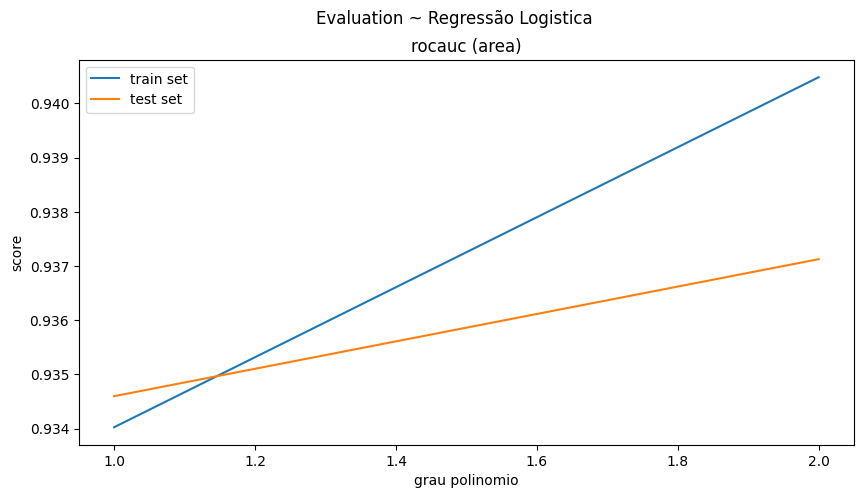

In [18]:
labels = ['train set', 'test set']
scores = {
    'ROC_AUC': [],
}
exps = list(range(1, 3))
best_cv_rocauc_reglog = -np.inf
best_exp = None

for i in exps:
    X_train_i, poly, scaler = transform_train_set(X_train, i)
    
    X_cv_i = poly.transform(X_cv)
    X_cv_i = scaler.transform(X_cv_i)

    model_i = LogisticRegression(max_iter=1000)
    model_i.fit(X_train_i, y_train)

    # train val
    y_pred_prob = model_i.predict_proba(X_train_i)[:, 1]
    y_true = y_train

    false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_pred_prob)
    train_rocauc = auc(false_positive_rate, true_positive_rate)

    # cv val
    y_pred_prob = model_i.predict_proba(X_cv_i)[:, 1]
    y_true = y_cv

    false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_pred_prob)
    cv_rocauc = auc(false_positive_rate, true_positive_rate)

    scores['ROC_AUC'].append([train_rocauc, cv_rocauc])

    if cv_rocauc > best_cv_rocauc_reglog:
        best_cv_rocauc_reglog = cv_rocauc
        best_exp = i

print(f'grau melhor ajustado sob dados de validação: {best_exp}.')
print(f"ROC-AUC ~> train: {scores['ROC_AUC'][best_exp-1][0]}, cv: {scores['ROC_AUC'][best_exp-1][1]}")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.set_title('rocauc (area)')
ax.set_xlabel('grau polinomio')
ax.set_ylabel('score')
ax.plot(exps, scores['ROC_AUC'], label=labels)
ax.legend()

plt.suptitle('Evaluation ~ Regressão Logistica')
plt.show()